In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import matplotlib.cm as cm
import matplotlib.colors as colors
from urllib.request import urlopen

### Puissance

#### Version récursive

In [2]:
def mat_pow(m: np.ndarray, n: int) -> np.ndarray:
    nl, nc = m.shape
    if nl != nc:
        raise ValueError("La matrice n'est pas carrée")
    if n == 0:
        return np.eye(nl)
    else:
        return m.dot(mat_pow(m, n - 1))
        

In [3]:
m = np.array([[1,2],[3,4]])
mat_pow(m, 5)

array([[1069., 1558.],
       [2337., 3406.]])

#### Version non récursive (impérative)

In [4]:
def mat_pow2(m: np.ndarray, n: int) -> np.ndarray:
    nl, nc = m.shape
    if nl != nc:
        raise ValueError("La matrice n'est pas carrée")
    p = np.eye(nl)
    for _ in range(1, n + 1) :
        p = p.dot(m)
    return p

In [5]:
mat_pow2(m, 5)

array([[1069., 1558.],
       [2337., 3406.]])

### Coloration

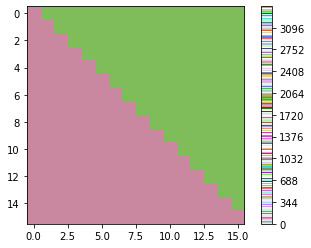

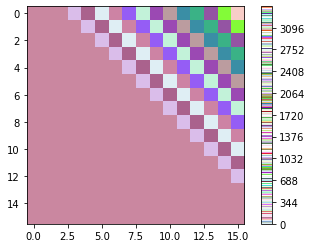

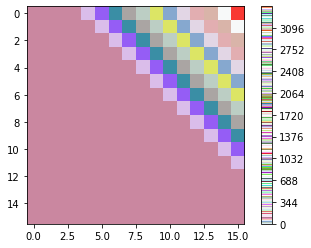

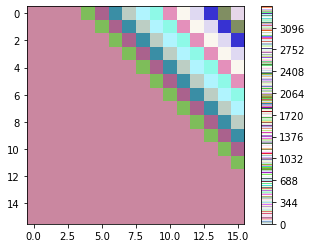

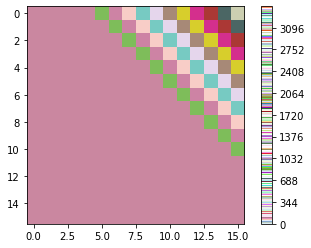

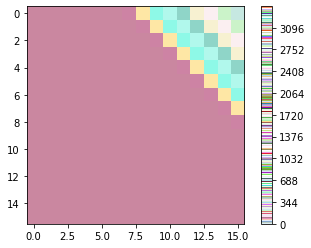

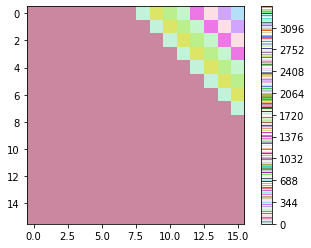

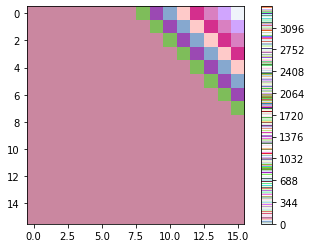

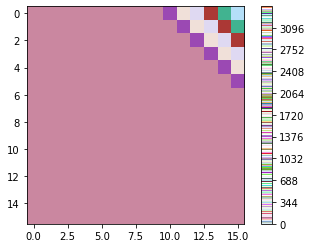

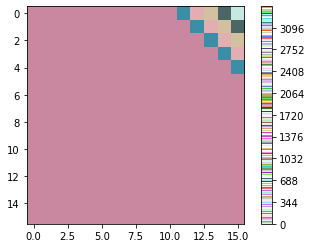

In [6]:

taille = 16 # taille de la matrice

Z = np.array([[1 if i < j else 0 for j in range(taille)] for i in range(taille)])

nf = 10
mats = [mat_pow(Z,i + 1) for i in range(nf)]
n = int(np.max(mats) + 2)

# Fabrication d'une barre de couleurs adaptée
cols = []
for i in range(n):
    cols.append(tuple([np.random.rand() for _ in range(4)]))
mes_couleurs = colors.ListedColormap(cols) 
ma_norme = colors.BoundaryNorm(range(len(cols)), mes_couleurs.N, clip=True)
# Fin de la fabrication de la colormap

for i in range(nf):
    plt.clf()
    im = plt.imshow(mat_pow(Z,i + 1), cmap=mes_couleurs, norm=ma_norme)
    cb = plt.colorbar()
    plt.show()

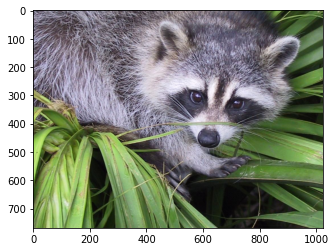

In [7]:
cb.remove()
mystere = misc.face()
plt.imshow(mystere)
plt.show()


In [8]:
def neg1(photo: np.ndarray) -> np.ndarray:
    nl, nc, _ = photo.shape
    photo_neg = np.zeros((nl,nc,3), dtype='uint8')
    for i in range(nl):
        for j in range(nc):
            photo_neg[i,j] = 255 - photo[i, j]
    return photo_neg

In [9]:
def neg2(photo: np.ndarray) -> np.ndarray:
    return np.array([[255 - pixel for pixel in ligne] for ligne in photo])

##### Fonction d'ordre supérieur

On crée une fonction qui prend une photo et une transformation en paramètres et affiche la photo transformée. On n'aura plus qu'à crééer la fonction aui transforme un pixel pour afficher le résultat sans avoir à répéter tout le mécanisme commun de création

In [10]:
def transforme_par_px(photo, change):
    new = np.array([[change(pixel) for pixel in ligne] for ligne in photo])
    plt.imshow(new)
    plt.show()
    return new

In [11]:
def neg_pix(pixel):
    return 255 - pixel

In [12]:
def grise_pix1(pixel):
    g = np.sum(pixel) // 3
    return np.array([g, g, g], dtype='uint8')

In [232]:
def seuil_pix(pixel, seuil=128):
    p_g = grise_pix(pixel)
    return p_g - int(seuil**2/p_g[0]) if p_g[0] > seuil else [0,0,0]

def bw_pix(pixel, seuil=128):
    p_g = grise_pix(pixel)
    return [255,255,255] if p_g[0] > seuil else [0,0,0]

In [18]:
from urllib.request import urlretrieve
url = "http://4everstatic.com/images/850xX/drole/dessins/kermit-the-frog,-grenouille,-sourire-136324.jpg"
urlretrieve(url, filename="./kermit.jpg")
kermit = plt.imread("./kermit.jpg")

In [19]:
def retourne_h(im:np.ndarray) -> np.ndarray:
    nl, nc, _ = im.shape
    return np.array([[im[nl - 1 - i, j] for j in range(nc)] for i in range(nl)])

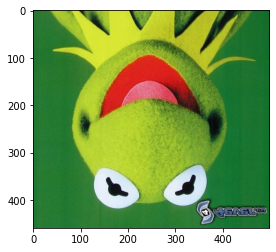

In [20]:
plt.imshow(retourne_h(kermit))

In [21]:
def un_sur_deux(im:np.ndarray) -> np.ndarray:
    nl, nc, _ = im.shape
    return np.array([[im[i, 2*j] for j in range(nc//2)] for i in range(nl)])

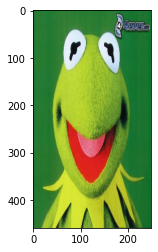

In [22]:
plt.imshow(un_sur_deux(kermit))

In [23]:
def ratio_im(im:np.ndarray, ratio: float) -> np.ndarray:
    nl, nc, _ = im.shape
    return np.array([[im[i, int(j/ratio)] for j in range(int(nc*ratio))] for i in range(nl)])

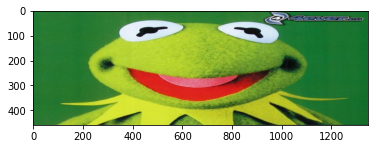

In [24]:
plt.imshow(ratio_im(kermit, 2.7))

## Énergie d'un pixel


### Luminance 

Nous allons avoir besoin de détecter des *contours* que nous assimilerons à des changements d'*intensité lumineuse* ou plutôt de *luminance*. Pour obtenir les niveaux de gris précédemment, nous avons fait la moyenne des composantes RGB. Or elles n'ont pas la meme importance dans le calcul de la luminance. De plus leur "influence" n'est pas linéaire (2 fois plus d'intensité ne veut pas dire 2 fois plus de luminance). Il y a une évolution exponentielle qui correspond aussi à la perception de l'œil humain.

On commence d'abord à corriger les coefficients RGB. Voici la correction correspondant au standard sRGB utilisé sur les écrans d'ordinateur:

$$
V' = \begin{cases} 1,055\times V_S^{1/2,4} - 0,055 \quad \text{ si } 0,0031308 < V_S \leqslant 1\\
12,92\times V_S \quad \text{ si } 0,0031308\geqslant V_S \geqslant 0\end{cases}
$$

avec $V_S$ le signal électrique de chaque composante RGB rapporté sur $[0,1]$.

On calcule ensuite la luminance : $Y=0,2126R'+0,7152G'+0,0722B'$.

Construisez une fonction qui renvoie la matrice de luminance.

In [25]:
def grise_pix(pixel):
    r, g, b = pixel
    lin = lambda vs : 1.055*vs**(1/24) - 0.055 if 0.0031308 <vs<=1 else 12.92*vs
    for vs in [r,g,b]:
        vs = int(255*lin(vs/255))
    g = int(0.2126*r + 0.7152*g+0.0722*b)
    return np.array([g, g, g], dtype='uint8')

In [26]:
def niveau(pixel, n: int) -> np.ndarray:
    r, g, b = pixel
    lin = lambda vs : 1.055*vs**(1/24) - 0.055 if 0.0031308 <vs<=1 else 12.92*vs
    for vs in [r,g,b]:
        vs = int(255*lin(vs/255))
    g = int(0.2126*r + 0.7152*g+0.0722*b)
    niv = 256 // n
    gn = (g//niv) * niv
    return np.array([gn, gn, gn], dtype='uint8')

In [27]:
niveau([165,165,165],4)

array([128, 128, 128], dtype=uint8)

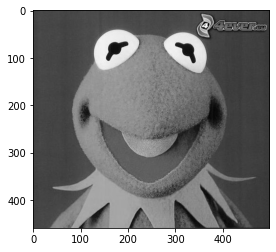

In [28]:
kermit_g_moyen = transforme_par_px(kermit, grise_pix1)

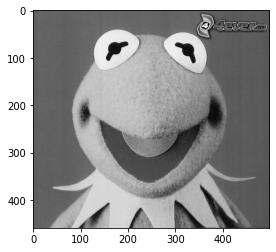

In [29]:
kermit_g = transforme_par_px(kermit, grise_pix)

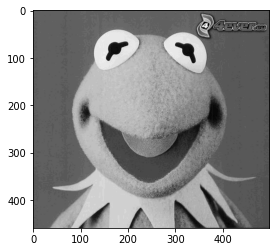

In [30]:
kermit_4 = transforme_par_px(kermit, lambda px: niveau(px, 32))

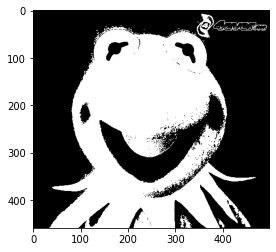

In [233]:
def seuil(im, s):
    return transforme_par_px(im, lambda px: seuil_pix(px, s))

def bw(im, s):
    return transforme_par_px(im, lambda px: bw_pix(px, s))

kermit_seuil = bw(kermit, 110)

### Gradient

En physique, lorsqu'on étudie les échanges d'énergie thermique entre des corps, on calcule le *gradient* $\nabla T(x,y)$ de température à savoir le vecteur de coordonnées $\left(\dfrac{\partial T}{\partial x},\dfrac{\partial T}{\partial y} \right)$ si l'on travaille dans le plan. C'est un vecteur orthogonal aux courbes isothermes. 
On peut remplacer la température par la luminance. Le problème est que le calcul du gradient nécessite l'existence d'une fonction différentiable alors que notre image est une matrice avec des valeurs discrètes : pas de calcul de dérivées possible.

Il existe de nombreuses méthodes. Nous prendrons la plus simple: $$\nabla I(i,j)\approx \left(\frac{I(i+1, j)-I(i-1, j)}{2},\frac{I(i, j+1)-I(i, j-1)}{2}\right)$$.

L'énergie retenue sera la norme de ce vecteur.

In [218]:
def norme(x: float, y: float) -> float:
    return np.sqrt(x**2 + y**2)

def conv_median(img: np.ndarray, n: int) -> np.ndarray:
    h, w, _ = img.shape
    f = np.zeros((h,w,3),dtype='uint8')
    for i in range(n, h - n):
        for j in range(n , w - n):
            g = int(np.median(img[i-n:i+1+n, j-n:j+n+1,0]))
            f[i, j] = [g, g, g]
    return f

def convolution(img: np.ndarray, filtre: np.ndarray) -> np.ndarray:
    h, w, _ = img.shape
    f = np.zeros((h, w, 3), dtype = 'uint8')
    for i in range(1, h - 1):
        for j in range(1 , w - 1):
            voisins = img[i-1:i+2, j-1:j+2, 0]
            g = int(np.sum(voisins * filtre))
            f[i, j] = [g, g, g]
    return f
            
            
            
def energie(im: np.ndarray) -> np.ndarray:
    h, w, _ = im.shape
    e = np.zeros(im.shape, dtype='uint8')
    for i in range(1, h - 1):
        for j in range(1 , w - 1):
            dx = (int(im[i+1, j,0]) - int(im[i-1, j,0])) // 2
            dy = (int(im[i, j+1,0]) - int(im[i, j-1,0])) // 2
            e[i, j] = 255 - int(norme(dx,dy))
    return e

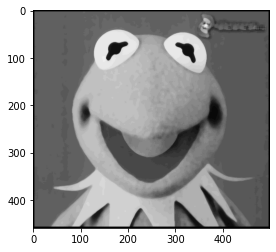

In [207]:
plt.imshow(conv_median(kermit_4,3))

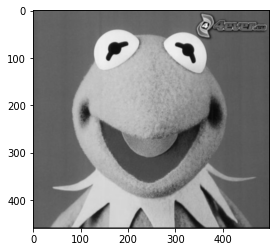

In [208]:
gauss = (1/16)*np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])
kermit_gauss = convolution(kermit_g, gauss)
plt.imshow(kermit_gauss)

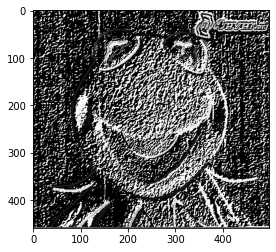

In [209]:
contour1 = np.array([[1,0,-1],[0,0,0,],[-1,0,1]])
contour2 = 0.5*np.array([[0,-1,0],[-1,0,1],[0,1,0]])
canny = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
plt.imshow(convolution(kermit_gauss, contour2))

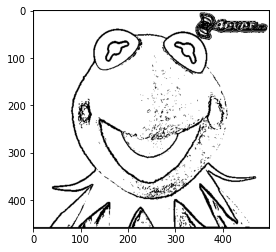

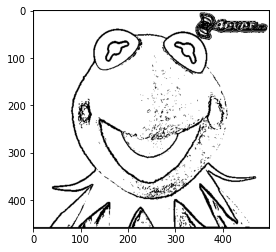

In [239]:
c = energie(kermit_gauss)
plt.imshow(bw(c,245))

In [217]:
i,j = 150,330
img = kermit_g
img[i-1:i+2,j-1:j+2,0], int(np.sum(img[i-1:i+2,j-1:j+2,0]*gauss))

(array([[174, 175, 168],
        [173, 173, 166],
        [164, 163, 158]], dtype=uint8),
 169)

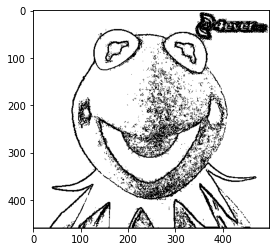

In [202]:
plt.imshow(energie(kermit_g))

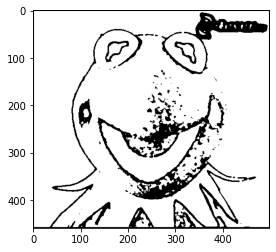

In [204]:
plt.imshow(conv_median((energie(kermit_g)),2))

In [36]:
from urllib.request import urlretrieve
url2 = "https://media.cdnws.com/_i/63827/59/197/59/tomate-copie-346-346-filled.jpeg"
urlretrieve(url2, filename="./tomate.jpg")
tomate = plt.imread("./tomate.jpg")

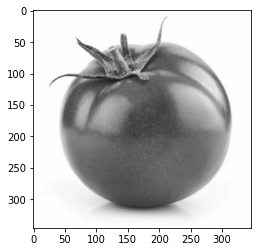

In [120]:
tomate_g = transforme_par_px(tomate, grise_pix)

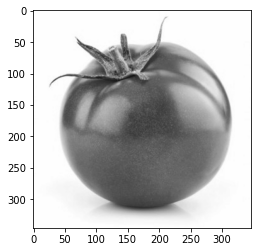

In [37]:
tomate_4 = transforme_par_px(tomate, lambda px: niveau(px, 128))

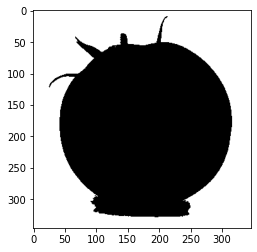

In [245]:
tomate_seuil = transforme_par_px(tomate, lambda im: bw_pix(im, 230))

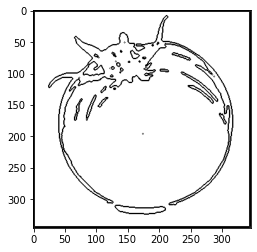

In [196]:
plt.imshow(energie(flou(energie(tomate_g),2)))

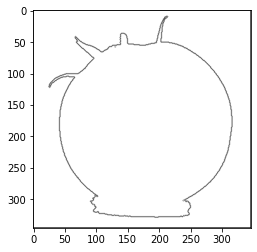

In [246]:
plt.imshow(energie(tomate_seuil))

In [247]:
from urllib.request import urlretrieve
url3 = "https://img.over-blog.com/170x170/3/10/47/74/Dossier-4/banane.jpg"
urlretrieve(url3, filename="./banane.jpg")
banane = plt.imread("./banane.jpg")

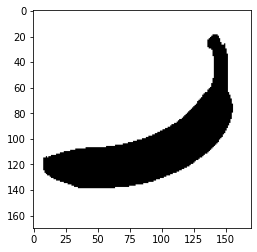

In [248]:
banane_seuil = transforme_par_px(banane, lambda im: bw_pix(im, 230))

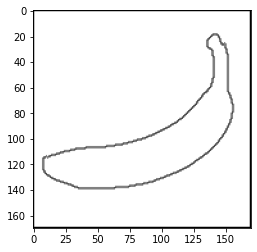

In [249]:
plt.imshow(energie(banane_seuil))

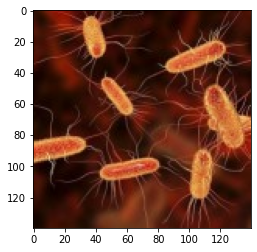

In [318]:
#url4 = "https://www.rtflash.fr/sites/default/files/imagecache/format_article/microbes_et_bacteries_modifient_notre_comportement.jpg"
url4 = "https://mens-en-gezondheid.infonu.nl/artikel-foto-upload/aandoeningen/73800-ehec-bacterie-symptomen-bloedige-diarree-en-buikkrampen.jpg?74af6"
#url4 = "https://thumbs.dreamstime.com/t/bleu-de-cinq-microbes-vu-dans-un-microscope-57162039.jpg"
urlretrieve(url4, filename="./bacterie.jpg")
bacterie = plt.imread("./bacterie.jpg")
plt.imshow(bacterie)

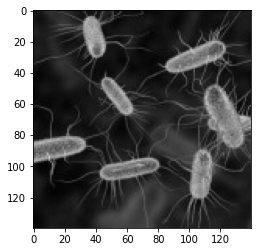

In [319]:
bacterie_g = transforme_par_px(bacterie, grise_pix)

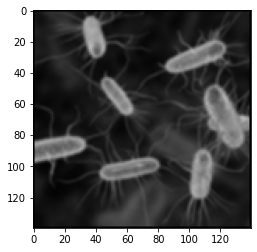

In [320]:
bacterie_gauss = convolution(bacterie_g, gauss)
plt.imshow(bacterie_gauss)

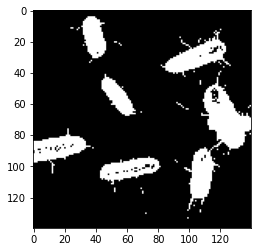

In [332]:
bacterie_seuil = transforme_par_px(bacterie_g, lambda im: bw_pix(im, 90))

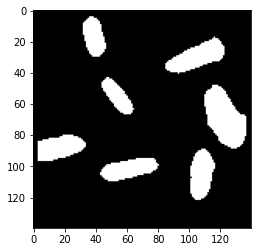

In [333]:
bacterie_gauss = flou(bacterie_seuil, 3)
plt.imshow(bacterie_gauss)

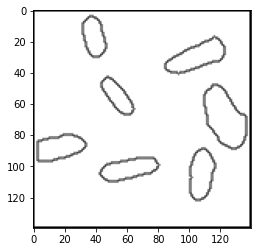

In [334]:
plt.imshow(energie(bacterie_gauss))

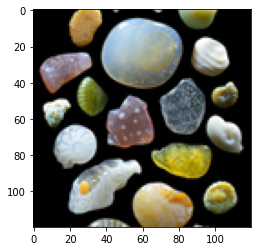

In [335]:
url5 = "https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fsandgrains.com%2FP_Maui-15B-web-copyT.jpg&f=1&nofb=1"
urlretrieve(url5, filename="./sable.jpg")
sable = plt.imread("./sable.jpg")
plt.imshow(sable)

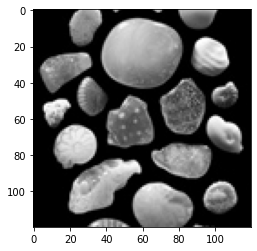

In [336]:
sable_g = transforme_par_px(sable, grise_pix)

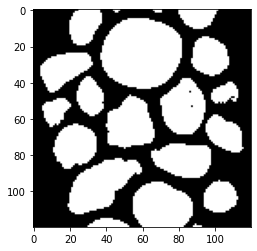

In [340]:
sable_seuil = transforme_par_px(sable_g, lambda im: bw_pix(im, 50))

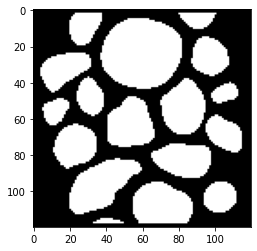

In [342]:
sable_gauss = flou(sable_seuil, 2)
plt.imshow(sable_gauss)

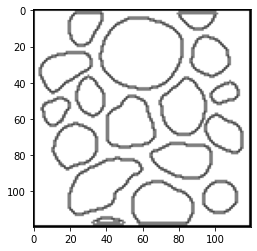

In [343]:
plt.imshow(energie(sable_gauss))